In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('data_for_student_case.csv')
df.shape

(290382, 17)

In [4]:
# Remove confused transaction 
df = df[df['simple_journal'] != 'Refused']
df.info()
print(df[df['simple_journal'] == 'Settled'].count()["simple_journal"])
print(df[df['simple_journal'] == 'Chargeback'].count()["simple_journal"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237036 entries, 0 to 290381
Data columns (total 17 columns):
txid                            237036 non-null int64
bookingdate                     237036 non-null object
issuercountrycode               237032 non-null object
txvariantcode                   237036 non-null object
bin                             237036 non-null float64
amount                          237036 non-null float64
currencycode                    237036 non-null object
shoppercountrycode              236694 non-null object
shopperinteraction              237036 non-null object
simple_journal                  237036 non-null object
cardverificationcodesupplied    223842 non-null object
cvcresponsecode                 237036 non-null int64
creationdate                    237036 non-null object
accountcode                     237036 non-null object
mail_id                         237036 non-null object
ip_id                           237036 non-null object
card_id  

In [5]:
# Convert bookingdate and creation date (string) into datetime 
cols = ['bookingdate', 'creationdate']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['creationdate'].describe()

count                  237036
unique                 232824
top       2015-08-22 10:12:01
freq                        6
first     2015-07-01 00:00:41
last      2015-10-31 23:59:12
Name: creationdate, dtype: object

In [9]:
# Add past fraud transaction count in the same ip id
grouped_ip = df.groupby("ip_id")
df['past_fraud_ip'] = 0 # new column past_fraud to store past fraud transaction count

for index, row in df.iterrows():
    grouped_same_ip = grouped_ip.get_group(row['ip_id'])
    grouped_same_ip_fraud = grouped_same_ip.loc[grouped_same_ip['simple_journal'] == 'Chargeback']
    grouped_same_ip_fraud_before = grouped_same_ip_fraud.loc[grouped_same_ip_fraud['creationdate'] < row['creationdate']]
    df.at[index,'past_fraud_ip'] = len(grouped_same_ip_fraud_before)
#     if(len(grouped_same_ip_fraud_before) != 0):
#         print(str(len(grouped_same_ip_fraud_before)) + "," + row['simple_journal'])
    

1,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
2,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
2,Chargeback
3,Chargeback
1,Chargeback
1,Settled
1,Settled
1,Settled
1,Settled
1,Settled
1,Chargeback
2,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
2,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
1,Chargeback
2,Chargeback
1,Chargeback
2,Chargeback
3,Chargeback
1,Chargeback
1,Chargeback
2,Chargeback
3,Chargeback
4,Chargeback
5,Chargeback
1,Settled
1,Settled
4,Settled
1,Chargeback
2,Chargeback
1,Chargeback
2,Chargeback
1,Chargeback
1,Settled
1,Settled
2,Settled


In [10]:
# Add past fraud transaction count in the same credit card
grouped_card = df.groupby("card_id")
df['past_fraud_card'] = 0 # new column past_fraud to store past fraud transaction count
# Add creation month, day
df['creationdate_day'] = pd.Timestamp('2019-01-05')

for index, row in df.iterrows():
    df.at[index,'creationdate_day'] = row['creationdate'].strftime("%Y-%m-%d")
    
    grouped_same_card = grouped_card.get_group(row['card_id'])
    grouped_same_card_fraud = grouped_same_card.loc[grouped_same_card['simple_journal'] == 'Chargeback']
    grouped_same_card_fraud_before = grouped_same_card_fraud.loc[grouped_same_card_fraud['creationdate'] < row['creationdate']]
    df.at[index,'past_fraud_card'] = len(grouped_same_card_fraud_before)

In [49]:
# Add number of transaction by same card within today
df['tran_today'] = 0
for index, row in df.iterrows():
    grouped_same_card = grouped_card.get_group(row['card_id'])
    tran_today = grouped_same_card[(grouped_same_card['creationdate'] < row['creationdate']) & (grouped_same_card['creationdate_day'] == row['creationdate_day'])]
    if len(tran_today) != 0:
        print(row['creationdate']) 
        print(tran_today['creationdate'])
        print("----")
    

# print(df['creationdate_day'])

2015-07-30 07:38:38
28   2015-07-30 07:30:54
Name: creationdate, dtype: datetime64[ns]
----
2015-08-01 09:29:45
35   2015-08-01 09:10:49
Name: creationdate, dtype: datetime64[ns]
----
2015-08-10 22:56:19
21623   2015-08-10 22:54:37
Name: creationdate, dtype: datetime64[ns]
----
2015-08-31 19:24:53
23126   2015-08-31 17:59:08
Name: creationdate, dtype: datetime64[ns]
----
2015-09-09 18:43:37
91   2015-09-09 18:34:34
Name: creationdate, dtype: datetime64[ns]
----
2015-10-31 02:15:25
151   2015-10-31 00:20:32
Name: creationdate, dtype: datetime64[ns]
----
2015-07-01 00:34:54
17906   2015-07-01 00:22:23
Name: creationdate, dtype: datetime64[ns]
----
2015-07-01 19:54:37
17977   2015-07-01 19:22:48
Name: creationdate, dtype: datetime64[ns]
----
2015-07-01 21:52:06
17929   2015-07-01 04:45:24
Name: creationdate, dtype: datetime64[ns]
----
2015-07-01 22:49:55
17925   2015-07-01 03:12:08
Name: creationdate, dtype: datetime64[ns]
----
2015-07-02 19:35:58
18101   2015-07-02 19:30:43
Name: creatio

2015-09-10 18:25:49
23867   2015-09-10 16:31:54
Name: creationdate, dtype: datetime64[ns]
----
2015-09-12 06:49:30
24006   2015-09-12 06:39:10
Name: creationdate, dtype: datetime64[ns]
----
2015-09-12 19:42:05
24023   2015-09-12 19:40:32
Name: creationdate, dtype: datetime64[ns]
----
2015-09-15 02:15:31
24231   2015-09-15 00:56:23
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 22:13:08
24440   2015-09-16 21:32:14
Name: creationdate, dtype: datetime64[ns]
----
2015-09-17 05:00:35
24474   2015-09-17 04:26:14
Name: creationdate, dtype: datetime64[ns]
----
2015-09-17 22:31:25
24501   2015-09-17 17:32:48
Name: creationdate, dtype: datetime64[ns]
----
2015-09-18 18:55:47
24549   2015-09-18 06:21:49
Name: creationdate, dtype: datetime64[ns]
----
2015-09-18 19:58:00
24594   2015-09-18 19:21:49
Name: creationdate, dtype: datetime64[ns]
----
2015-09-18 23:40:19
24536   2015-09-18 01:56:55
Name: creationdate, dtype: datetime64[ns]
----
2015-09-19 18:30:17
24665   2015-09-19 18:17:50
Na

2015-07-19 06:09:26
35453   2015-07-19 05:50:50
Name: creationdate, dtype: datetime64[ns]
----
2015-07-20 02:13:48
35649   2015-07-20 02:10:06
Name: creationdate, dtype: datetime64[ns]
----
2015-07-20 09:12:47
35685   2015-07-20 05:03:03
Name: creationdate, dtype: datetime64[ns]
----
2015-07-21 08:01:57
36005   2015-07-21 07:48:52
Name: creationdate, dtype: datetime64[ns]
----
2015-07-22 05:44:37
36165   2015-07-22 00:28:13
Name: creationdate, dtype: datetime64[ns]
----
2015-07-22 21:05:26
36307   2015-07-22 10:34:18
Name: creationdate, dtype: datetime64[ns]
----
2015-07-23 02:31:27
36439   2015-07-23 02:21:41
Name: creationdate, dtype: datetime64[ns]
----
2015-07-26 08:08:10
37075   2015-07-26 08:00:14
Name: creationdate, dtype: datetime64[ns]
----
2015-07-26 10:48:17
37116   2015-07-26 10:26:20
Name: creationdate, dtype: datetime64[ns]
----
2015-07-26 12:55:34
37027   2015-07-26 03:54:50
Name: creationdate, dtype: datetime64[ns]
----
2015-07-27 13:45:51
37305   2015-07-27 09:54:15
Na

2015-08-22 15:05:28
43464   2015-08-22 14:52:51
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 08:24:05
43545   2015-08-23 08:17:08
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 14:57:05
43626   2015-08-23 14:48:09
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 05:06:04
43693   2015-08-24 04:39:09
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 08:43:44
43726   2015-08-24 07:15:10
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 08:53:53
43711   2015-08-24 05:44:34
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 10:35:05
43757   2015-08-24 09:32:58
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 13:37:48
43711   2015-08-24 05:44:34
43748   2015-08-24 08:53:53
Name: creationdate, dtype: datetime64[ns]
----
2015-08-25 03:42:07
43882   2015-08-25 03:33:47
Name: creationdate, dtype: datetime64[ns]
----
2015-08-25 03:46:50
43882   2015-08-25 03:33:47
43884   2015-08-25 03:42:07
Name: creationdate, dtype: datetime64[ns]

2015-09-22 03:25:36
49937   2015-09-22 03:11:12
Name: creationdate, dtype: datetime64[ns]
----
2015-09-22 04:20:48
49969   2015-09-22 04:12:25
Name: creationdate, dtype: datetime64[ns]
----
2015-09-22 13:37:01
49913   2015-09-22 00:42:21
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 07:08:58
50255   2015-09-23 04:27:49
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 16:07:01
50329   2015-09-23 08:45:58
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 16:33:21
50514   2015-09-23 16:28:21
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 18:51:49
50503   2015-09-23 15:58:53
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 21:42:47
50432   2015-09-23 12:50:18
Name: creationdate, dtype: datetime64[ns]
----
2015-09-24 05:14:38
50616   2015-09-24 05:04:04
Name: creationdate, dtype: datetime64[ns]
----
2015-09-24 10:07:46
50724   2015-09-24 09:08:34
Name: creationdate, dtype: datetime64[ns]
----
2015-09-24 12:27:01
50724   2015-09-24 09:08:34
50

2015-10-30 12:53:37
58434   2015-10-30 12:42:30
Name: creationdate, dtype: datetime64[ns]
----
2015-10-30 14:01:40
58433   2015-10-30 12:40:04
Name: creationdate, dtype: datetime64[ns]
----
2015-10-31 03:54:00
58512   2015-10-31 03:51:15
Name: creationdate, dtype: datetime64[ns]
----
2015-10-31 07:35:47
58552   2015-10-31 07:33:34
Name: creationdate, dtype: datetime64[ns]
----
2015-07-27 17:28:57
99887   2015-07-27 17:04:53
99894   2015-07-27 17:13:15
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 09:45:48
113436   2015-08-06 09:41:19
113440   2015-08-06 09:43:31
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 10:18:45
58642    2015-08-06 09:45:48
113436   2015-08-06 09:41:19
113440   2015-08-06 09:43:31
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 10:21:33
58642    2015-08-06 09:45:48
58643    2015-08-06 10:18:45
113436   2015-08-06 09:41:19
113440   2015-08-06 09:43:31
Name: creationdate, dtype: datetime64[ns]
----
2015-08-28 17:46:17
146389   2015-0

2015-07-04 13:32:01
64272   2015-07-04 12:46:17
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 13:55:16
64261   2015-07-04 12:34:19
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 14:52:36
64030   2015-07-04 06:59:39
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 16:26:32
64245   2015-07-04 12:21:38
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 17:05:27
64099   2015-07-04 10:14:14
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 17:40:17
64088   2015-07-04 10:01:30
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 18:02:04
64655   2015-07-04 17:20:27
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 18:07:05
64717   2015-07-04 17:59:54
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 18:37:02
64733   2015-07-04 18:07:29
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 19:14:07
64583   2015-07-04 16:31:35
Name: creationdate, dtype: datetime64[ns]
----
2015-07-04 19:37:01
64553   2015-07-04 16:18:49
Na

2015-07-09 16:47:27
72901   2015-07-09 15:23:20
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 17:19:35
72945   2015-07-09 16:10:28
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 17:51:10
72428   2015-07-09 00:41:32
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 17:59:59
72428   2015-07-09 00:41:32
73057   2015-07-09 17:51:10
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 18:06:13
72428   2015-07-09 00:41:32
73057   2015-07-09 17:51:10
73069   2015-07-09 17:59:59
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 18:27:14
73084   2015-07-09 18:10:27
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 21:35:49
73311   2015-07-09 21:04:49
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 22:30:30
73421   2015-07-09 22:23:12
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 22:34:13
73402   2015-07-09 22:12:59
Name: creationdate, dtype: datetime64[ns]
----
2015-07-09 22:58:49
73474   2015-07-09 22:53:03
Name: creatio

2015-07-11 20:40:22
77393   2015-07-11 20:24:14
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 20:43:20
75700   2015-07-11 01:12:10
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 20:56:57
77052   2015-07-11 17:42:24
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 21:10:34
75629   2015-07-11 00:42:35
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 21:59:00
75737   2015-07-11 01:31:57
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 22:01:25
77520   2015-07-11 21:27:28
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 22:05:25
76084   2015-07-11 10:06:48
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 22:47:37
77486   2015-07-11 21:09:28
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 23:04:40
75981   2015-07-11 09:02:58
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 23:32:28
76186   2015-07-11 11:03:21
Name: creationdate, dtype: datetime64[ns]
----
2015-07-11 23:45:07
76162   2015-07-11 10:51:15
Na

2015-07-17 20:45:18
86225   2015-07-17 20:28:23
Name: creationdate, dtype: datetime64[ns]
----
2015-07-17 21:16:59
86257   2015-07-17 21:04:28
Name: creationdate, dtype: datetime64[ns]
----
2015-07-17 22:26:37
86352   2015-07-17 22:20:46
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 07:25:28
86571   2015-07-18 06:27:41
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 11:03:54
86536   2015-07-18 01:52:54
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 12:18:12
86662   2015-07-18 11:34:24
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 17:07:15
86676   2015-07-18 11:48:04
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 17:23:31
86975   2015-07-18 17:14:12
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 18:45:07
87079   2015-07-18 18:38:21
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 19:29:57
87108   2015-07-18 19:08:24
Name: creationdate, dtype: datetime64[ns]
----
2015-07-18 21:57:58
87253   2015-07-18 21:42:49
Na

2015-07-25 11:05:32
95749   2015-07-25 10:48:07
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 11:36:09
95804   2015-07-25 11:30:49
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 11:48:53
95811   2015-07-25 11:34:40
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 14:12:23
96023   2015-07-25 13:45:01
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 15:23:14
96108   2015-07-25 14:29:43
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 16:39:40
96252   2015-07-25 15:59:35
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 16:53:57
95615   2015-07-25 04:18:36
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 17:51:56
96056   2015-07-25 14:05:55
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 18:22:18
96468   2015-07-25 17:56:58
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 18:23:02
96500   2015-07-25 18:17:13
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 18:34:44
96502   2015-07-25 18:19:01
Na

2015-07-29 02:38:40
101800   2015-07-29 02:02:08
Name: creationdate, dtype: datetime64[ns]
----
2015-07-29 12:49:05
102001   2015-07-29 12:43:15
Name: creationdate, dtype: datetime64[ns]
----
2015-07-29 13:57:07
101835   2015-07-29 07:26:22
Name: creationdate, dtype: datetime64[ns]
----
2015-07-29 14:46:57
102151   2015-07-29 14:43:26
Name: creationdate, dtype: datetime64[ns]
----
2015-07-29 18:50:50
101779   2015-07-29 01:19:33
Name: creationdate, dtype: datetime64[ns]
----
2015-07-29 20:23:30
101876   2015-07-29 09:42:21
Name: creationdate, dtype: datetime64[ns]
----
2015-07-29 22:05:21
101780   2015-07-29 01:19:58
Name: creationdate, dtype: datetime64[ns]
----
2015-07-30 00:46:36
102869   2015-07-30 00:40:23
Name: creationdate, dtype: datetime64[ns]
----
2015-07-30 01:56:33
102901   2015-07-30 01:38:18
Name: creationdate, dtype: datetime64[ns]
----
2015-07-30 02:02:37
102901   2015-07-30 01:38:18
102906   2015-07-30 01:56:33
Name: creationdate, dtype: datetime64[ns]
----
2015-07-30 

2015-08-03 13:04:47
108257   2015-08-03 01:06:29
108446   2015-08-03 11:26:36
108473   2015-08-03 11:44:40
108482   2015-08-03 11:48:55
108486   2015-08-03 11:51:52
Name: creationdate, dtype: datetime64[ns]
----
2015-08-03 13:22:29
108257   2015-08-03 01:06:29
108446   2015-08-03 11:26:36
108473   2015-08-03 11:44:40
108482   2015-08-03 11:48:55
108486   2015-08-03 11:51:52
108594   2015-08-03 13:04:47
Name: creationdate, dtype: datetime64[ns]
----
2015-08-03 14:08:06
108257   2015-08-03 01:06:29
108446   2015-08-03 11:26:36
108473   2015-08-03 11:44:40
108482   2015-08-03 11:48:55
108486   2015-08-03 11:51:52
108594   2015-08-03 13:04:47
108610   2015-08-03 13:22:29
Name: creationdate, dtype: datetime64[ns]
----
2015-08-03 14:19:23
108257   2015-08-03 01:06:29
108446   2015-08-03 11:26:36
108473   2015-08-03 11:44:40
108482   2015-08-03 11:48:55
108486   2015-08-03 11:51:52
108594   2015-08-03 13:04:47
108610   2015-08-03 13:22:29
108693   2015-08-03 14:08:06
Name: creationdate, dtype

2015-08-04 16:34:04
110259   2015-08-04 10:34:02
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 17:07:20
110298   2015-08-04 11:09:13
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 17:28:39
110259   2015-08-04 10:34:02
110768   2015-08-04 16:34:04
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 17:32:55
110287   2015-08-04 11:01:52
110293   2015-08-04 11:06:17
110304   2015-08-04 11:14:12
110326   2015-08-04 11:26:32
110344   2015-08-04 11:42:24
110365   2015-08-04 12:02:55
110399   2015-08-04 12:23:02
110715   2015-08-04 16:03:06
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 17:55:25
110323   2015-08-04 11:25:02
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 18:44:01
110274   2015-08-04 10:48:56
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 18:55:46
110840   2015-08-04 17:08:32
Name: creationdate, dtype: datetime64[ns]
----
2015-08-04 19:27:46
111042   2015-08-04 19:11:14
Name: creationdate, dtype: datetime64[ns]
----


2015-08-06 19:17:19
113940   2015-08-06 16:16:43
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 20:18:45
114184   2015-08-06 18:49:42
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 22:29:30
114395   2015-08-06 21:12:28
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 22:32:07
114416   2015-08-06 21:25:08
Name: creationdate, dtype: datetime64[ns]
----
2015-08-06 23:31:03
113715   2015-08-06 13:40:42
Name: creationdate, dtype: datetime64[ns]
----
2015-08-07 02:11:00
114830   2015-08-07 02:03:20
Name: creationdate, dtype: datetime64[ns]
----
2015-08-07 02:18:28
114830   2015-08-07 02:03:20
114834   2015-08-07 02:11:00
Name: creationdate, dtype: datetime64[ns]
----
2015-08-07 07:06:22
114892   2015-08-07 06:59:55
Name: creationdate, dtype: datetime64[ns]
----
2015-08-07 07:46:32
114896   2015-08-07 07:20:07
Name: creationdate, dtype: datetime64[ns]
----
2015-08-07 08:04:08
114891   2015-08-07 06:54:49
Name: creationdate, dtype: datetime64[ns]
----
2015-08-07 

2015-08-10 16:06:31
119026   2015-08-10 12:30:43
119052   2015-08-10 12:56:33
119101   2015-08-10 13:24:25
119111   2015-08-10 13:32:58
119124   2015-08-10 13:43:45
119141   2015-08-10 13:53:50
119151   2015-08-10 13:57:54
119217   2015-08-10 14:27:58
119240   2015-08-10 14:36:34
119269   2015-08-10 15:01:05
119285   2015-08-10 15:11:02
119307   2015-08-10 15:22:16
119361   2015-08-10 15:52:24
Name: creationdate, dtype: datetime64[ns]
----
2015-08-10 16:12:05
119026   2015-08-10 12:30:43
119052   2015-08-10 12:56:33
119101   2015-08-10 13:24:25
119111   2015-08-10 13:32:58
119124   2015-08-10 13:43:45
119141   2015-08-10 13:53:50
119151   2015-08-10 13:57:54
119217   2015-08-10 14:27:58
119240   2015-08-10 14:36:34
119269   2015-08-10 15:01:05
119285   2015-08-10 15:11:02
119307   2015-08-10 15:22:16
119361   2015-08-10 15:52:24
119375   2015-08-10 16:06:31
Name: creationdate, dtype: datetime64[ns]
----
2015-08-10 16:20:55
119026   2015-08-10 12:30:43
119052   2015-08-10 12:56:33
11910

2015-08-11 17:04:19
120710   2015-08-11 13:22:16
Name: creationdate, dtype: datetime64[ns]
----
2015-08-11 18:06:09
121086   2015-08-11 17:58:15
Name: creationdate, dtype: datetime64[ns]
----
2015-08-11 18:10:58
121086   2015-08-11 17:58:15
121096   2015-08-11 18:06:09
Name: creationdate, dtype: datetime64[ns]
----
2015-08-11 19:01:06
120841   2015-08-11 14:49:15
Name: creationdate, dtype: datetime64[ns]
----
2015-08-11 21:50:17
121386   2015-08-11 21:01:30
Name: creationdate, dtype: datetime64[ns]
----
2015-08-11 22:26:25
121360   2015-08-11 20:47:35
Name: creationdate, dtype: datetime64[ns]
----
2015-08-11 23:10:12
120717   2015-08-11 13:29:36
Name: creationdate, dtype: datetime64[ns]
----
2015-08-12 03:37:57
121843   2015-08-12 03:16:28
Name: creationdate, dtype: datetime64[ns]
----
2015-08-12 06:55:11
41027   2015-08-12 06:24:25
41037   2015-08-12 06:43:03
Name: creationdate, dtype: datetime64[ns]
----
2015-08-12 12:40:03
122016   2015-08-12 12:30:47
Name: creationdate, dtype: date

2015-08-16 10:17:08
127203   2015-08-16 08:55:23
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 13:47:38
127366   2015-08-16 12:45:37
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 15:06:36
127545   2015-08-16 14:54:25
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 16:09:32
127617   2015-08-16 15:40:42
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 17:26:19
127746   2015-08-16 17:10:19
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 18:09:45
127705   2015-08-16 16:45:19
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 18:18:14
127835   2015-08-16 18:14:25
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 18:31:38
127807   2015-08-16 17:54:37
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 22:55:34
128083   2015-08-16 20:53:18
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 22:59:36
128283   2015-08-16 22:38:31
Name: creationdate, dtype: datetime64[ns]
----
2015-08-16 23:20:15
127521   2015-08-16 

2015-08-18 22:32:36
131715   2015-08-18 21:29:30
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 22:43:39
131868   2015-08-18 22:03:23
131941   2015-08-18 22:20:42
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 22:52:58
131049   2015-08-18 18:05:56
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 22:56:17
132021   2015-08-18 22:35:54
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 23:00:32
132084   2015-08-18 22:50:52
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 23:10:52
131284   2015-08-18 19:16:15
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 23:13:03
131540   2015-08-18 20:39:19
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 23:14:23
130034   2015-08-18 11:40:10
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 23:14:52
131303   2015-08-18 19:23:36
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 23:15:07
131420   2015-08-18 20:01:34
Name: creationdate, dtype: datetime64[ns]
----
2015-08-18 

2015-08-20 15:39:35
134482   2015-08-20 10:54:36
134505   2015-08-20 11:18:32
134517   2015-08-20 11:33:20
Name: creationdate, dtype: datetime64[ns]
----
2015-08-20 15:43:19
134832   2015-08-20 15:32:24
Name: creationdate, dtype: datetime64[ns]
----
2015-08-20 15:51:20
134283   2015-08-20 01:15:33
134301   2015-08-20 01:44:43
134310   2015-08-20 01:56:18
134327   2015-08-20 02:50:23
134330   2015-08-20 03:00:03
134621   2015-08-20 13:01:42
134632   2015-08-20 13:09:10
134648   2015-08-20 13:22:22
134764   2015-08-20 14:42:47
134772   2015-08-20 14:47:39
Name: creationdate, dtype: datetime64[ns]
----
2015-08-20 15:53:40
134339   2015-08-20 04:01:17
Name: creationdate, dtype: datetime64[ns]
----
2015-08-20 16:23:06
134898   2015-08-20 16:12:33
Name: creationdate, dtype: datetime64[ns]
----
2015-08-20 16:38:30
134283   2015-08-20 01:15:33
134301   2015-08-20 01:44:43
134310   2015-08-20 01:56:18
134327   2015-08-20 02:50:23
134330   2015-08-20 03:00:03
134621   2015-08-20 13:01:42
134632 

2015-08-22 21:48:23
138411   2015-08-22 20:57:19
Name: creationdate, dtype: datetime64[ns]
----
2015-08-22 22:53:15
138580   2015-08-22 22:48:26
Name: creationdate, dtype: datetime64[ns]
----
2015-08-22 23:11:36
138501   2015-08-22 22:01:09
Name: creationdate, dtype: datetime64[ns]
----
2015-08-22 23:14:20
138610   2015-08-22 23:11:10
Name: creationdate, dtype: datetime64[ns]
----
2015-08-22 23:35:42
138622   2015-08-22 23:17:46
Name: creationdate, dtype: datetime64[ns]
----
2015-08-22 23:51:18
138640   2015-08-22 23:36:19
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 10:31:32
138828   2015-08-23 10:21:19
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 12:58:47
138963   2015-08-23 12:45:12
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 13:12:35
138992   2015-08-23 13:00:03
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 13:37:41
139023   2015-08-23 13:20:50
Name: creationdate, dtype: datetime64[ns]
----
2015-08-23 14:23:37
139077   2015-08-23 

2015-08-24 20:17:47
141204   2015-08-24 19:56:04
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 20:32:37
140995   2015-08-24 17:38:06
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 21:05:53
140906   2015-08-24 16:40:31
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 21:21:14
141235   2015-08-24 20:18:43
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 22:24:07
141243   2015-08-24 20:23:42
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 22:42:39
141484   2015-08-24 22:23:24
Name: creationdate, dtype: datetime64[ns]
----
2015-08-24 22:53:38
141368   2015-08-24 21:28:27
Name: creationdate, dtype: datetime64[ns]
----
2015-08-25 01:36:53
141730   2015-08-25 00:49:41
Name: creationdate, dtype: datetime64[ns]
----
2015-08-25 02:03:27
141695   2015-08-25 00:21:25
Name: creationdate, dtype: datetime64[ns]
----
2015-08-25 08:04:21
141829   2015-08-25 07:43:23
Name: creationdate, dtype: datetime64[ns]
----
2015-08-25 10:55:01
141923   2015-08-25 

2015-08-28 21:09:10
147847   2015-08-28 19:59:03
Name: creationdate, dtype: datetime64[ns]
----
2015-08-28 21:24:03
147693   2015-08-28 18:40:43
Name: creationdate, dtype: datetime64[ns]
----
2015-08-28 21:59:28
147889   2015-08-28 20:22:09
Name: creationdate, dtype: datetime64[ns]
----
2015-08-28 22:58:56
148195   2015-08-28 22:55:29
Name: creationdate, dtype: datetime64[ns]
----
2015-08-28 23:34:56
147504   2015-08-28 16:55:03
Name: creationdate, dtype: datetime64[ns]
----
2015-08-29 01:18:49
148323   2015-08-29 00:19:08
Name: creationdate, dtype: datetime64[ns]
----
2015-08-29 01:45:00
148423   2015-08-29 01:37:22
Name: creationdate, dtype: datetime64[ns]
----
2015-08-29 02:21:21
148448   2015-08-29 02:15:09
Name: creationdate, dtype: datetime64[ns]
----
2015-08-29 03:43:08
148451   2015-08-29 02:20:23
Name: creationdate, dtype: datetime64[ns]
----
2015-08-29 05:18:57
148495   2015-08-29 05:08:32
Name: creationdate, dtype: datetime64[ns]
----
2015-08-29 08:39:49
148493   2015-08-29 

2015-08-31 19:30:12
152241   2015-08-31 18:37:37
Name: creationdate, dtype: datetime64[ns]
----
2015-08-31 22:08:36
152614   2015-08-31 21:54:59
Name: creationdate, dtype: datetime64[ns]
----
2015-08-31 22:21:10
152176   2015-08-31 18:08:35
Name: creationdate, dtype: datetime64[ns]
----
2015-08-31 23:29:26
152846   2015-08-31 23:12:40
Name: creationdate, dtype: datetime64[ns]
----
2015-09-01 05:17:04
153091   2015-09-01 04:35:08
Name: creationdate, dtype: datetime64[ns]
----
2015-09-01 05:30:20
153091   2015-09-01 04:35:08
153095   2015-09-01 05:17:04
Name: creationdate, dtype: datetime64[ns]
----
2015-09-01 05:38:47
153091   2015-09-01 04:35:08
153095   2015-09-01 05:17:04
153098   2015-09-01 05:30:20
Name: creationdate, dtype: datetime64[ns]
----
2015-09-01 05:51:19
153091   2015-09-01 04:35:08
153095   2015-09-01 05:17:04
153098   2015-09-01 05:30:20
153099   2015-09-01 05:38:47
Name: creationdate, dtype: datetime64[ns]
----
2015-09-01 06:13:09
153091   2015-09-01 04:35:08
153095   

2015-09-02 22:38:17
155565   2015-09-02 00:56:51
Name: creationdate, dtype: datetime64[ns]
----
2015-09-02 22:50:34
156510   2015-09-02 19:22:16
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 11:28:55
157171   2015-09-03 04:55:58
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 13:05:33
157388   2015-09-03 13:04:35
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 13:23:06
157389   2015-09-03 13:04:49
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 13:25:10
157389   2015-09-03 13:04:49
157410   2015-09-03 13:23:06
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 14:04:42
157388   2015-09-03 13:04:35
157391   2015-09-03 13:05:33
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 14:04:55
157388   2015-09-03 13:04:35
157391   2015-09-03 13:05:33
157461   2015-09-03 14:04:42
Name: creationdate, dtype: datetime64[ns]
----
2015-09-03 14:06:20
157388   2015-09-03 13:04:35
157391   2015-09-03 13:05:33
157461   2015-09-03 14:04:42
157462   

2015-09-08 18:46:14
164845   2015-09-08 18:17:00
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 18:54:37
164414   2015-09-08 13:17:49
164554   2015-09-08 14:52:45
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 19:26:58
164859   2015-09-08 18:25:23
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 20:09:11
164956   2015-09-08 19:23:44
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 20:43:36
164757   2015-09-08 17:28:03
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 20:51:27
165069   2015-09-08 20:26:10
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 22:00:56
165276   2015-09-08 21:58:02
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 22:56:55
165423   2015-09-08 22:39:18
Name: creationdate, dtype: datetime64[ns]
----
2015-09-08 23:10:25
164829   2015-09-08 18:06:41
Name: creationdate, dtype: datetime64[ns]
----
2015-09-09 02:13:13
165758   2015-09-09 01:37:09
Name: creationdate, dtype: datetime64[ns]
----
2015-09-09 

2015-09-10 17:43:17
167392   2015-09-10 15:05:01
167399   2015-09-10 15:10:31
167410   2015-09-10 15:18:47
167425   2015-09-10 15:28:38
167435   2015-09-10 15:36:24
167442   2015-09-10 15:45:25
167457   2015-09-10 15:56:42
167465   2015-09-10 16:12:44
167470   2015-09-10 16:17:29
167481   2015-09-10 16:21:41
167497   2015-09-10 16:33:18
167503   2015-09-10 16:38:30
167512   2015-09-10 16:44:04
Name: creationdate, dtype: datetime64[ns]
----
2015-09-10 17:43:19
167411   2015-09-10 15:18:49
167419   2015-09-10 15:25:21
167426   2015-09-10 15:28:39
167436   2015-09-10 15:36:26
167441   2015-09-10 15:45:19
167462   2015-09-10 16:03:36
167466   2015-09-10 16:12:47
167471   2015-09-10 16:17:31
167480   2015-09-10 16:21:40
167496   2015-09-10 16:33:16
167504   2015-09-10 16:38:31
167513   2015-09-10 16:44:07
Name: creationdate, dtype: datetime64[ns]
----
2015-09-10 17:57:26
167392   2015-09-10 15:05:01
167399   2015-09-10 15:10:31
167410   2015-09-10 15:18:47
167425   2015-09-10 15:28:38
16743

2015-09-11 18:18:59
168988   2015-09-11 18:07:20
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 18:36:32
169004   2015-09-11 18:19:40
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 18:56:36
169004   2015-09-11 18:19:40
169031   2015-09-11 18:36:32
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 19:54:33
168684   2015-09-11 14:14:12
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 20:14:04
168816   2015-09-11 16:07:24
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 21:31:40
168474   2015-09-11 11:02:47
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 21:42:56
169229   2015-09-11 21:27:21
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 22:15:42
169268   2015-09-11 21:50:21
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 22:40:00
169315   2015-09-11 22:23:38
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 22:59:56
169349   2015-09-11 22:48:12
Name: creationdate, dtype: datetime64[ns]
----
2015-09-11 

2015-09-13 23:53:52
171999   2015-09-13 23:29:28
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 03:09:20
172112   2015-09-14 02:32:24
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 15:41:19
172466   2015-09-14 14:41:12
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 16:10:52
172590   2015-09-14 16:08:32
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 16:32:45
172601   2015-09-14 16:14:04
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 16:39:11
172537   2015-09-14 15:33:04
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 16:48:45
172316   2015-09-14 12:32:54
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 16:58:19
172601   2015-09-14 16:14:04
172618   2015-09-14 16:32:45
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 17:02:49
172584   2015-09-14 15:59:20
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 17:44:07
172512   2015-09-14 15:10:37
Name: creationdate, dtype: datetime64[ns]
----
2015-09-14 

2015-09-16 11:35:42
175265   2015-09-16 11:25:02
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 12:24:54
175170   2015-09-16 08:40:50
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 16:11:39
175221   2015-09-16 10:34:37
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 16:49:42
175574   2015-09-16 16:40:58
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 16:51:51
175221   2015-09-16 10:34:37
175555   2015-09-16 16:11:39
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 17:01:35
175441   2015-09-16 14:18:11
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 18:42:37
175703   2015-09-16 18:21:52
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 18:44:45
175715   2015-09-16 18:32:46
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 18:46:52
175703   2015-09-16 18:21:52
175734   2015-09-16 18:42:37
Name: creationdate, dtype: datetime64[ns]
----
2015-09-16 18:51:48
175715   2015-09-16 18:32:46
175737   2015-09-16 18:44:45


2015-09-21 13:07:01
181554   2015-09-21 11:29:10
181565   2015-09-21 11:37:46
181572   2015-09-21 11:44:50
181578   2015-09-21 11:50:49
181591   2015-09-21 12:02:37
181606   2015-09-21 12:15:13
181614   2015-09-21 12:21:13
181626   2015-09-21 12:26:28
181648   2015-09-21 12:44:25
181659   2015-09-21 12:52:23
Name: creationdate, dtype: datetime64[ns]
----
2015-09-21 13:29:40
181554   2015-09-21 11:29:10
181565   2015-09-21 11:37:46
181572   2015-09-21 11:44:50
181578   2015-09-21 11:50:49
181591   2015-09-21 12:02:37
181606   2015-09-21 12:15:13
181614   2015-09-21 12:21:13
181626   2015-09-21 12:26:28
181648   2015-09-21 12:44:25
181659   2015-09-21 12:52:23
181677   2015-09-21 13:07:01
Name: creationdate, dtype: datetime64[ns]
----
2015-09-21 13:31:35
181554   2015-09-21 11:29:10
181565   2015-09-21 11:37:46
181572   2015-09-21 11:44:50
181578   2015-09-21 11:50:49
181591   2015-09-21 12:02:37
181606   2015-09-21 12:15:13
181614   2015-09-21 12:21:13
181626   2015-09-21 12:26:28
18164

2015-09-21 16:23:43
181967   2015-09-21 14:55:26
182040   2015-09-21 15:13:42
Name: creationdate, dtype: datetime64[ns]
----
2015-09-21 16:32:04
181554   2015-09-21 11:29:10
181565   2015-09-21 11:37:46
181572   2015-09-21 11:44:50
181578   2015-09-21 11:50:49
181591   2015-09-21 12:02:37
181606   2015-09-21 12:15:13
181614   2015-09-21 12:21:13
181626   2015-09-21 12:26:28
181648   2015-09-21 12:44:25
181659   2015-09-21 12:52:23
181677   2015-09-21 13:07:01
181713   2015-09-21 13:29:40
181717   2015-09-21 13:31:35
181739   2015-09-21 13:41:32
181791   2015-09-21 14:03:55
181857   2015-09-21 14:25:42
181913   2015-09-21 14:38:34
181978   2015-09-21 14:59:17
182006   2015-09-21 15:04:29
182050   2015-09-21 15:15:50
182131   2015-09-21 15:40:34
182161   2015-09-21 15:51:33
182187   2015-09-21 15:57:51
182200   2015-09-21 16:07:46
182220   2015-09-21 16:15:34
Name: creationdate, dtype: datetime64[ns]
----
2015-09-21 16:59:01
182163   2015-09-21 15:52:03
Name: creationdate, dtype: datetim

2015-09-23 02:42:07
185273   2015-09-23 02:25:54
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 12:23:33
185448   2015-09-23 12:11:52
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 12:26:39
185444   2015-09-23 12:06:07
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 17:33:53
185731   2015-09-23 17:23:57
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 20:41:43
186000   2015-09-23 20:39:34
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 21:06:41
186033   2015-09-23 21:01:42
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 21:08:59
186033   2015-09-23 21:01:42
186042   2015-09-23 21:06:41
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 21:14:43
186033   2015-09-23 21:01:42
186042   2015-09-23 21:06:41
186049   2015-09-23 21:08:59
Name: creationdate, dtype: datetime64[ns]
----
2015-09-23 21:25:01
186033   2015-09-23 21:01:42
186042   2015-09-23 21:06:41
186049   2015-09-23 21:08:59
186055   2015-09-23 21:14:43
Name: cre

2015-09-29 15:46:54
192565   2015-09-29 10:43:47
Name: creationdate, dtype: datetime64[ns]
----
2015-09-29 16:40:36
192866   2015-09-29 14:57:55
Name: creationdate, dtype: datetime64[ns]
----
2015-09-29 17:20:01
193005   2015-09-29 17:02:37
Name: creationdate, dtype: datetime64[ns]
----
2015-09-29 18:09:19
192856   2015-09-29 14:50:03
Name: creationdate, dtype: datetime64[ns]
----
2015-09-29 19:35:13
193229   2015-09-29 19:31:53
Name: creationdate, dtype: datetime64[ns]
----
2015-09-29 19:42:13
192366   2015-09-29 00:23:33
Name: creationdate, dtype: datetime64[ns]
----
2015-09-29 21:34:23
192336   2015-09-29 00:02:09
Name: creationdate, dtype: datetime64[ns]
----
2015-09-30 06:46:24
193908   2015-09-30 06:40:42
Name: creationdate, dtype: datetime64[ns]
----
2015-09-30 12:06:46
193857   2015-09-30 01:48:49
Name: creationdate, dtype: datetime64[ns]
----
2015-09-30 14:43:24
194278   2015-09-30 14:13:45
Name: creationdate, dtype: datetime64[ns]
----
2015-09-30 15:33:28
194361   2015-09-30 

2015-10-05 14:49:01
201434   2015-10-05 14:25:39
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 15:12:34
201492   2015-10-05 14:59:33
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 15:23:05
201515   2015-10-05 15:20:15
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 15:24:06
201517   2015-10-05 15:20:53
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 15:43:07
201536   2015-10-05 15:33:54
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 17:33:54
201722   2015-10-05 17:25:56
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 18:10:36
201772   2015-10-05 18:08:12
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 21:03:08
201388   2015-10-05 14:01:44
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 21:56:27
202131   2015-10-05 21:18:37
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 22:11:52
202131   2015-10-05 21:18:37
202212   2015-10-05 21:56:27
Name: creationdate, dtype: datetime64[ns]
----
2015-10-05 

2015-10-08 12:27:36
207231   2015-10-08 12:02:08
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 12:30:46
206655   2015-10-08 10:24:25
206713   2015-10-08 10:32:58
206965   2015-10-08 11:17:37
207142   2015-10-08 11:45:42
207326   2015-10-08 12:16:25
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 12:41:33
205681   2015-10-08 02:01:54
205692   2015-10-08 02:06:55
205717   2015-10-08 02:19:27
205731   2015-10-08 02:27:48
205783   2015-10-08 02:58:12
205789   2015-10-08 03:01:22
205804   2015-10-08 03:18:27
205824   2015-10-08 03:53:30
207273   2015-10-08 12:07:33
207306   2015-10-08 12:13:25
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 12:41:37
205730   2015-10-08 02:27:38
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 12:43:09
205681   2015-10-08 02:01:54
205692   2015-10-08 02:06:55
205717   2015-10-08 02:19:27
205731   2015-10-08 02:27:48
205783   2015-10-08 02:58:12
205789   2015-10-08 03:01:22
205804   2015-10-08 03:18:27
205824   2015-10

2015-10-08 17:34:10
209248   2015-10-08 17:16:53
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 17:54:33
205834   2015-10-08 04:21:58
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 17:55:01
209390   2015-10-08 17:36:13
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 18:12:54
208622   2015-10-08 15:33:16
209349   2015-10-08 17:32:37
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 18:17:48
209526   2015-10-08 17:56:01
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 18:19:35
209607   2015-10-08 18:07:59
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 18:39:10
208852   2015-10-08 16:11:54
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 18:42:39
209848   2015-10-08 18:39:07
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 18:44:45
206095   2015-10-08 08:31:19
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 19:11:35
210032   2015-10-08 19:03:34
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 

2015-10-09 02:25:27
214342   2015-10-09 02:02:21
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 03:01:31
214113   2015-10-09 01:24:52
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 03:06:22
214430   2015-10-09 02:58:00
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 10:31:41
214604   2015-10-09 10:26:50
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 12:32:41
213660   2015-10-09 00:43:37
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 13:46:40
214748   2015-10-09 12:49:18
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 14:53:48
214672   2015-10-09 11:43:55
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 15:14:04
214748   2015-10-09 12:49:18
214810   2015-10-09 13:46:40
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 15:23:28
214748   2015-10-09 12:49:18
214810   2015-10-09 13:46:40
214882   2015-10-09 15:14:04
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 16:57:40
214748   2015-10-09 12:49:18


2015-10-17 15:20:59
223349   2015-10-17 14:26:40
Name: creationdate, dtype: datetime64[ns]
----
2015-10-17 22:17:05
223820   2015-10-17 21:36:07
Name: creationdate, dtype: datetime64[ns]
----
2015-10-18 02:40:44
224021   2015-10-18 02:20:19
Name: creationdate, dtype: datetime64[ns]
----
2015-10-18 03:03:45
224021   2015-10-18 02:20:19
224029   2015-10-18 02:40:44
Name: creationdate, dtype: datetime64[ns]
----
2015-10-18 13:51:22
224207   2015-10-18 13:42:01
Name: creationdate, dtype: datetime64[ns]
----
2015-10-18 21:05:45
224637   2015-10-18 18:47:00
Name: creationdate, dtype: datetime64[ns]
----
2015-10-18 22:23:41
224998   2015-10-18 22:11:01
Name: creationdate, dtype: datetime64[ns]
----
2015-10-19 04:09:43
225189   2015-10-19 00:47:23
Name: creationdate, dtype: datetime64[ns]
----
2015-10-19 11:22:21
225341   2015-10-19 11:20:11
Name: creationdate, dtype: datetime64[ns]
----
2015-10-19 11:32:57
225348   2015-10-19 11:30:35
Name: creationdate, dtype: datetime64[ns]
----
2015-10-19 

2015-10-28 21:19:32
235239   2015-10-28 20:37:56
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 06:37:34
235565   2015-10-29 01:52:13
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 09:24:43
235565   2015-10-29 01:52:13
235585   2015-10-29 06:37:34
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 13:22:02
235776   2015-10-29 12:40:56
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 13:26:07
235666   2015-10-29 10:22:55
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 13:36:41
235803   2015-10-29 13:06:43
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 14:35:44
235906   2015-10-29 14:26:41
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 14:55:56
235592   2015-10-29 08:00:20
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 17:39:55
236095   2015-10-29 17:22:40
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 19:05:43
236185   2015-10-29 18:36:27
Name: creationdate, dtype: datetime64[ns]
----
2015-10-29 

2015-07-15 16:11:09
274210   2015-07-15 15:16:50
Name: creationdate, dtype: datetime64[ns]
----
2015-07-19 16:40:52
274615   2015-07-19 13:27:45
Name: creationdate, dtype: datetime64[ns]
----
2015-07-21 13:29:04
274886   2015-07-21 12:17:13
Name: creationdate, dtype: datetime64[ns]
----
2015-07-21 19:00:54
274944   2015-07-21 18:38:59
Name: creationdate, dtype: datetime64[ns]
----
2015-07-23 10:50:33
275155   2015-07-23 10:02:55
Name: creationdate, dtype: datetime64[ns]
----
2015-07-24 16:01:10
275296   2015-07-24 07:08:07
Name: creationdate, dtype: datetime64[ns]
----
2015-07-24 21:43:09
275329   2015-07-24 11:28:16
Name: creationdate, dtype: datetime64[ns]
----
2015-07-25 21:45:12
275479   2015-07-25 03:31:14
Name: creationdate, dtype: datetime64[ns]
----
2015-07-26 23:24:09
275850   2015-07-26 22:27:48
Name: creationdate, dtype: datetime64[ns]
----
2015-07-27 02:19:38
275890   2015-07-27 02:08:26
Name: creationdate, dtype: datetime64[ns]
----
2015-07-28 17:42:07
276185   2015-07-28 

2015-10-08 19:18:48
287486   2015-10-08 19:05:24
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 21:41:29
287668   2015-10-08 21:05:35
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 21:47:42
287044   2015-10-08 11:26:57
287050   2015-10-08 11:34:09
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 22:01:05
287796   2015-10-08 21:59:31
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 22:23:42
287838   2015-10-08 22:18:26
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 22:33:06
287209   2015-10-08 14:15:28
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 22:48:56
287865   2015-10-08 22:31:11
Name: creationdate, dtype: datetime64[ns]
----
2015-10-08 23:27:10
288015   2015-10-08 23:24:04
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 00:52:28
288103   2015-10-09 00:35:49
Name: creationdate, dtype: datetime64[ns]
----
2015-10-09 08:16:31
288144   2015-10-09 08:12:27
Name: creationdate, dtype: datetime64[ns]
----
2015-10-10 

Single variable exploration

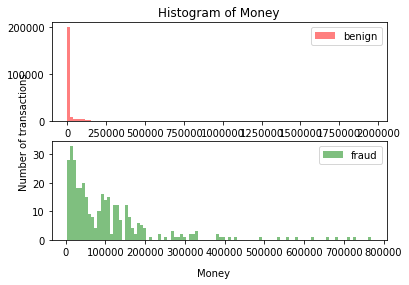

In [28]:
# Visualize money attribute
benign_data = df[df['simple_journal'] == 'Settled']
fraud_data = df[df['simple_journal'] == 'Chargeback']

f, axarr = plt.subplots(2)
kwargs = dict(alpha=0.5, bins=100)
axarr[0].hist(benign_data['amount'], **kwargs, color='r', label='benign')
axarr[0].legend()
axarr[1].hist(fraud_data['amount'], **kwargs, color='g', label='fraud')
axarr[1].legend()
f.text(0.5, 0.01, 'Money', ha='center', va='center')
f.text(0.06, 0.5, 'Number of transactions', ha='center', va='center', rotation='vertical')
axarr[0].set_title("Histogram of Money")
plt.show()

Bivariate analysis

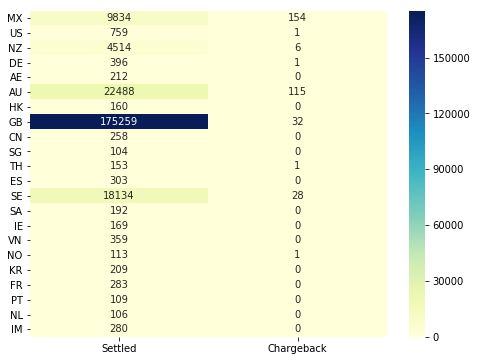

In [35]:
# country + simple_journal
country_list = df['shoppercountrycode'].unique()
result_list = ['Settled', 'Chargeback']
df_count = pd.DataFrame(index=country_list, columns=result_list, dtype='int64') # dataframe store counts
count = df.groupby(['shoppercountrycode','simple_journal']).size() # groupby count 

# Fill in 
for country in country_list:
    for result in result_list:
        if (country, result) in count:
            df_count.at[country, result] = int(count[country][result])
        else:
            df_count.at[country, result] = int(0)

# Drop countries which has less than 100 records             
df_count = df_count.drop(df_count[df_count['Settled'] + df_count['Chargeback'] < 100].index)
# print(df_count)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_count, annot=True, fmt='.0f',cmap="YlGnBu")
plt.savefig("country.png")

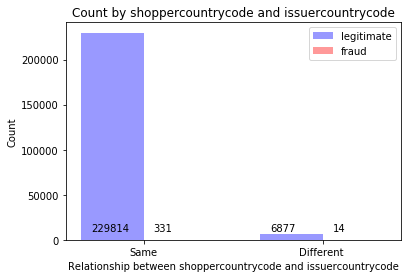

In [25]:
# relationship between shoppercountrycode and issuercountrycode
shopper_issue_same_benign = len(benign_data.loc[benign_data['shoppercountrycode'] == benign_data['issuercountrycode']])
shopper_issue_diff_benign = len(benign_data.loc[benign_data['shoppercountrycode'] != benign_data['issuercountrycode']])
shopper_issue_same_fraud = len(fraud_data.loc[fraud_data['shoppercountrycode'] == fraud_data['issuercountrycode']])
shopper_issue_diff_fraud = len(fraud_data.loc[fraud_data['shoppercountrycode'] != fraud_data['issuercountrycode']])

shopper_issue_benign = (shopper_issue_same_benign, shopper_issue_diff_benign)
shopper_issue_fraud = (shopper_issue_same_fraud, shopper_issue_diff_fraud)

fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.35

rects1 = ax.bar(index, shopper_issue_benign, bar_width,
                alpha=0.4, color='b', label='legitimate')

rects2 = ax.bar(index + bar_width, shopper_issue_fraud, bar_width,
                alpha=0.4, color='r',label='fraud')

ax.set_xlabel('Relationship between shoppercountrycode and issuercountrycode')
ax.set_ylabel('Count')
ax.set_title('Count by shoppercountrycode and issuercountrycode')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Same', 'Different '))
ax.legend()
# display value 
for i, v in enumerate(shopper_issue_benign):
    ax.text(i-.12, v/shopper_issue_benign[i] + 10000, str(shopper_issue_benign[i]), color='black')
for i, v in enumerate(shopper_issue_fraud):
    ax.text(i-.12 + bar_width, v/shopper_issue_fraud[i] + 10000, str(shopper_issue_fraud[i]), color='black')

plt.show()

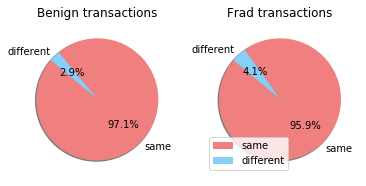

In [34]:
labels = ['same','different']
colors = ['lightcoral', 'lightskyblue']

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pie(shopper_issue_benign, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title("Benign transactions")
ax2.pie(shopper_issue_fraud, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax2.set_title("Fraud transactions")
ax2.legend()
plt.show()

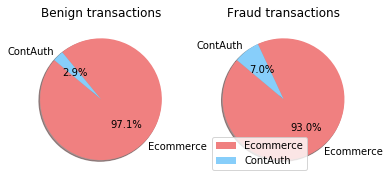

In [27]:
# shopperinteraction (Ecommerce or ContAuth)
ecommerce_benign = len(benign_data.loc[benign_data['shopperinteraction'] == 'Ecommerce'])
contAuth_benign = len(benign_data.loc[benign_data['shopperinteraction'] == 'ContAuth'])
ecommerce_fraud = len(fraud_data.loc[fraud_data['shopperinteraction'] == 'Ecommerce'])
contAuth_fraud = len(fraud_data.loc[fraud_data['shopperinteraction'] == 'ContAuth'])

labels = ['Ecommerce','ContAuth']
colors = ['lightcoral', 'lightskyblue']

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pie((ecommerce_benign, contAuth_benign), labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title("Benign transactions")
ax2.pie((ecommerce_fraud, contAuth_fraud), labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax2.set_title("Fraud transactions")
ax2.legend()
plt.savefig("shopperinteraction.png")
plt.show()

               0     1    2    3    4
benign  236684.0   7.0  0.0  0.0  0.0
fraud      309.0  24.0  7.0  3.0  2.0


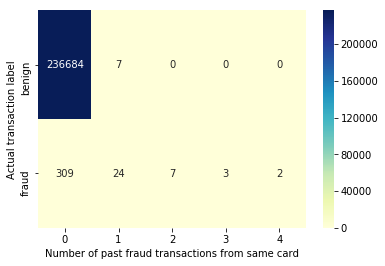

In [23]:
# Plot past fraud count from the same card

column_size = max(benign_data['past_fraud_card'].max() + 1, fraud_data['past_fraud_card'].max() + 1)
past_fraud_card_count = pd.DataFrame(index=['benign', 'fraud'], columns = range(0, column_size), dtype='int64')
for i in range(0, column_size):
    past_fraud_card_count.at['benign', i] = len(benign_data.loc[benign_data['past_fraud_card'] == i])
    past_fraud_card_count.at['fraud', i] = len(fraud_data.loc[fraud_data['past_fraud_card'] == i])

print(past_fraud_card_count)

sns.heatmap(past_fraud_card_count, annot=True, fmt='.0f',cmap="YlGnBu")
plt.xlabel("Number of past fraud transactions from same card")
plt.ylabel("Actual transaction label")
plt.show()

               0     1    2    3    4    5
benign  236680.0   9.0  1.0  0.0  1.0  0.0
fraud      307.0  24.0  9.0  3.0  1.0  1.0


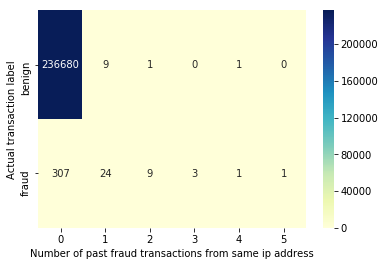

In [24]:
# Plot past fraud count from the same ip id

column_size = max(benign_data['past_fraud_ip'].max() + 1, fraud_data['past_fraud_ip'].max() + 1)
past_fraud_ip_count = pd.DataFrame(index=['benign', 'fraud'], columns = range(0, column_size), dtype='int64')
for i in range(0, column_size):
    past_fraud_ip_count.at['benign', i] = len(benign_data.loc[benign_data['past_fraud_ip'] == i])
    past_fraud_ip_count.at['fraud', i] = len(fraud_data.loc[fraud_data['past_fraud_ip'] == i])

print(past_fraud_ip_count)

sns.heatmap(past_fraud_ip_count, annot=True, fmt='.0f',cmap="YlGnBu")
plt.xlabel("Number of past fraud transactions from same ip address")
plt.ylabel("Actual transaction label")
plt.show()

In [ ]:
df['creationdate_day'] = pd.Timestamp('2019-01-05')